In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

import kornia
from mish_cuda import MishCuda

from tqdm.notebook import tqdm
from sklearn.utils import shuffle

PATH = Path('../..').resolve()

%matplotlib inline

seed = 12345

In [2]:
# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def root_mean_squared_error(preds, targs):  return torch.sqrt(F.mse_loss(preds.reshape(-1, 1), targs.reshape(-1, 1)))
def slope(p, y): return ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

# allow ColReader to look in different `pref` paths if needed
class ModifiedColReader():
    "Read `cols` in `row` with potential `pref` and `suff`"
    def __init__(self, cols, pref='', suff='', label_delim=None):
        store_attr(self, 'suff,label_delim')
        self.pref = str(pref) + os.path.sep if isinstance(pref, Path) else pref
        self.cols = L(cols)

    def _do_one(self, r, c):
        o = r[c] if isinstance(c, int) else r[c] if c=='name' else getattr(r, c)
        if len(self.pref)==0 and len(self.suff)==0 and self.label_delim is None: return o
        if self.label_delim is None and len(o) < 10: return f'{PATH}/images-OC/{o}{self.suff}'
        elif self.label_delim is None and len(o) >= 10: return f'{PATH}/images-nondetections/{o}{self.suff}' 
        else: return o.split(self.label_delim) if len(o)>0 else []

    def __call__(self, o, **kwargs):
        if len(self.cols) == 1: return self._do_one(o, self.cols[0])
        return L(self._do_one(o, c) for c in self.cols)

image_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

item_tfms = []
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize.from_stats(*image_stats)]

# Get trained model

In [4]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a40, path=PATH, bs=64)

# Check non-detections using model trained on a.40

In [5]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [6]:
nd_files = shuffle(get_image_files(f'{PATH}/images-nondetections/'), random_state=seed)

In [7]:
# check first 500

preds = np.zeros((500,))

for i, fn in enumerate(tqdm(nd_files[:500])):
    preds[i] = learn.predict(fn)[0]

(array([  8.,  27.,  47.,  72.,  74., 104., 100.,  54.,  12.,   2.]),
 array([-1.3979528 , -1.12351263, -0.84907246, -0.57463229, -0.30019212,
        -0.02575195,  0.24868822,  0.52312839,  0.79756856,  1.07200873,
         1.3464489 ]),
 <a list of 10 Patch objects>)

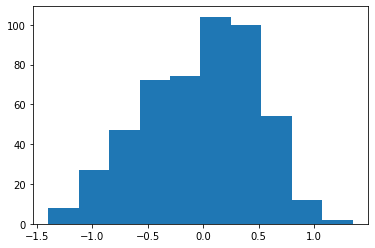

In [8]:
plt.hist(preds)

# Test model trained on combined learner

In [9]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-combined-1');

In [10]:
preds = np.zeros((500,))

for i, fn in enumerate(tqdm(nd_files[:500])):
    preds[i] = learn.predict(fn)[0]

(array([32., 36., 50., 54., 55., 72., 94., 83., 21.,  3.]),
 array([-1.83373499, -1.51542763, -1.19712026, -0.8788129 , -0.56050553,
        -0.24219817,  0.07610919,  0.39441656,  0.71272392,  1.03103129,
         1.34933865]),
 <a list of 10 Patch objects>)

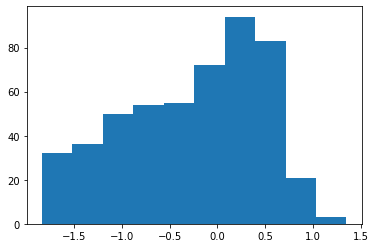

In [11]:
plt.hist(preds)

# Classify non-detections

In [12]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})
nd = pd.read_csv(f'{PATH}/results/nondetections/a100-nd_himass_lowz.csv', dtype={'objID': str})

nd['detected'] = False
a40['detected'] = True

In [13]:
a40['objID'] = a40.AGCNr.astype(str)
nd.objID = nd.objID.astype(str)

In [15]:
# get balanced classes
combined = pd.concat([
    a40[['objID', 'detected']],
    nd[['objID', 'detected']].sample(7399, random_state=seed)
])

combined.sample(5)

,objID,detected
21423,1237668495782903865,False
322,188854,True
3017,6622,True
462,180247,True
4236,221095,True


In [17]:
nd_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ModifiedColReader(['objID'], pref=(f'{PATH}/images-OC/'), suff='.jpg'),
    get_y=Pipeline([ColReader(['detected'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(nd_dblock, combined, path=PATH, bs=64)

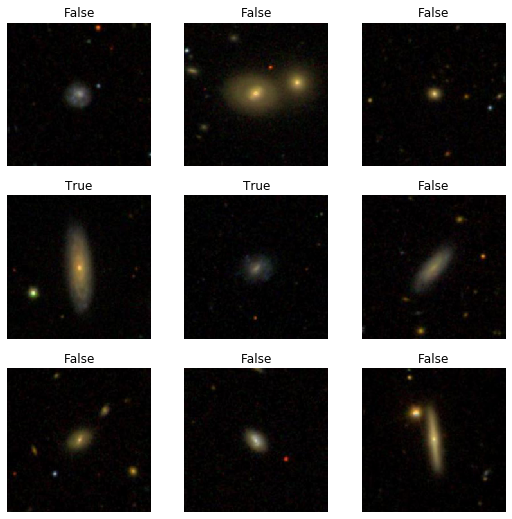

In [18]:
dls.show_batch()

In [19]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)
learn = Learner(dls, model, opt_func=ranger, metrics=[accuracy, RocAuc()])

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.00363078061491251)

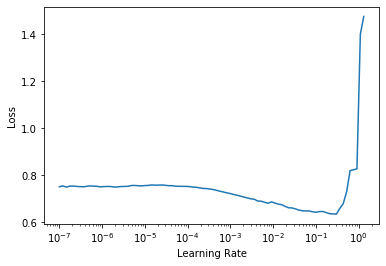

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.482214,0.434091,0.801622,01:06
1,0.450255,0.480077,0.761406,01:03
2,0.440393,0.459279,0.778304,01:03
3,0.445214,0.508117,0.759716,01:03
4,0.436368,0.423020,0.799932,01:03
5,0.438752,0.400043,0.817844,01:03
6,0.437792,0.529740,0.711727,01:03
7,0.416080,0.491070,0.771544,01:03
8,0.393557,0.368426,0.833052,01:03
9,0.388402,0.329385,0.855694,01:03


In [24]:
learn.save('fastai2-xresnet34-non_detections-1');

In [25]:
preds, trues = learn.get_preds()

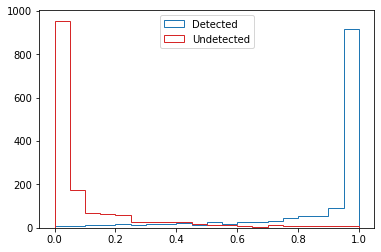

In [28]:
plt.hist(preds[trues == 1][:,1], bins=20, range=(0,1), histtype='step', color='C0', label='Detected')
plt.hist(preds[trues == 0][:,1], bins=20, range=(0,1), histtype='step', color='C3', label='Undetected')
plt.legend(loc='upper center')

## Longer training

In [48]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)
learn = Learner(dls, model, opt_func=ranger, metrics=[accuracy, RocAuc()])

In [49]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.490790,0.455985,0.794187,0.791640,01:03
1,0.437887,0.493254,0.781683,0.785542,01:03
2,0.439236,0.402204,0.813788,0.812087,01:03
3,0.438442,0.414145,0.810747,0.813006,01:03
4,0.428031,0.408632,0.811423,0.813487,01:03
5,0.428554,0.384856,0.822913,0.821014,01:03
6,0.409122,0.388987,0.824941,0.823413,01:03
7,0.390559,0.386950,0.840149,0.837258,01:03
8,0.376233,0.311399,0.866171,0.864664,01:03
9,0.362160,0.341006,0.864143,0.862070,01:03


In [50]:
learn.save('fastai2-xresnet34-non_detections-2');

In [52]:
preds, trues = learn.tta()

Text(0.5, 0, 'Predicted probability of detection')

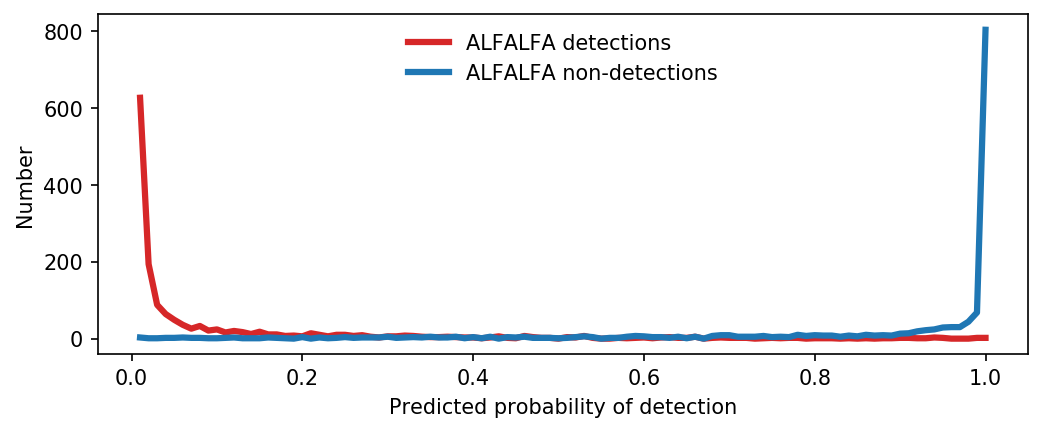

In [70]:
plt.figure(figsize=(8, 3), dpi=150)

y_det, x_det = np.histogram(preds[trues == 1][:,1], bins=100, range=(0,1))
y_non, x_non = np.histogram(preds[trues == 0][:,1], bins=100, range=(0,1))

plt.plot((x_non[:-1]+0.01), y_non, lw=3, color='C3', label=r'ALFALFA detections')
plt.plot((x_det[:-1]+0.01), y_det, lw=3, color='C0', label=r'ALFALFA non-detections')

plt.legend(loc='upper center', framealpha=0)

plt.ylabel('Number')
plt.xlabel('Predicted probability of detection')

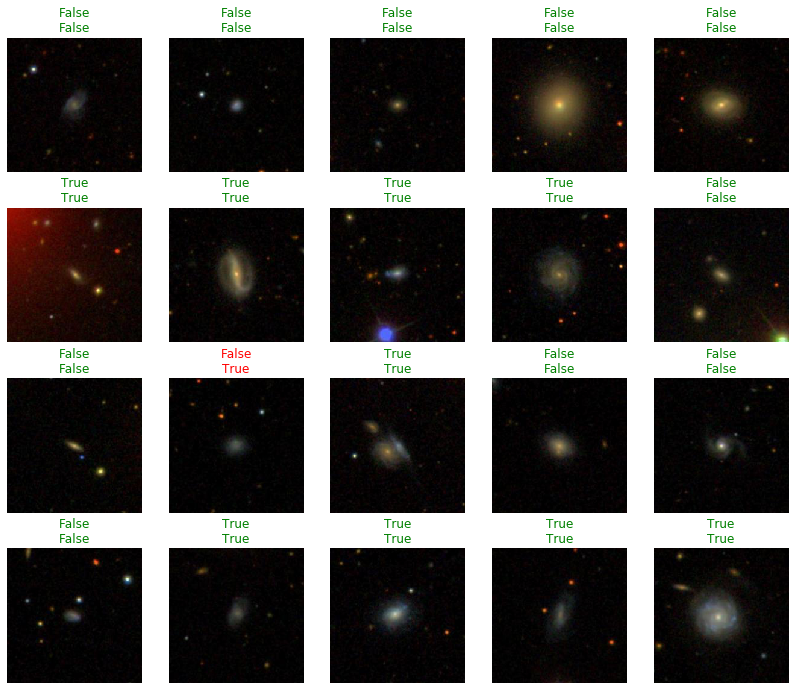

In [99]:
learn.show_results(max_n=20, nrows=4, ncols=5, figsize=(14, 12))

# Making predictions on xGASS and NIBLES

## xGASS detectability

In [106]:
xg_files = shuffle(get_image_files(f'{PATH}/images-xGASS/'), random_state=seed)
len(xg_files)

1179

In [128]:
xgass_detections = np.array([(learn.predict(fn)[0] == 'True') for fn in xg_files])

In [129]:
# nubmer of Trues
sum(xgass_detections)

341

## xGASS predictions

In [132]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=64)

In [133]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [135]:
xgass_predictions = np.array([learn.predict(fn)[0] for fn in xg_files])

([array([ 8., 21., 31., 39., 42., 70., 49., 41., 30., 10.]),
  array([ 68., 160., 231., 218., 176., 145.,  88.,  52.,  31.,  10.])],
 array([-1.34002256, -1.14164385, -0.94326514, -0.74488643, -0.54650772,
        -0.348129  , -0.14975029,  0.04862842,  0.24700713,  0.44538584,
         0.64376456]),
 <a list of 2 Lists of Patches objects>)

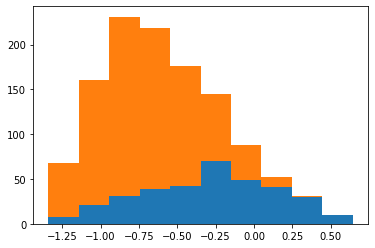

In [139]:
plt.hist([xgass_predictions[xgass_detections], xgass_predictions[~xgass_detections]], stacked=True)

In [145]:
xg_ids = np.array([xg_f.stem for xg_f in xg_files], dtype=int)

In [148]:
# re-index so that the ordering is same as predictions
xg.set_index('GASS', inplace=True)
xg = xg.loc[xg_ids]

In [152]:
xg['detected'] = xgass_detections
xg['fgas_pred'] = xgass_predictions

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

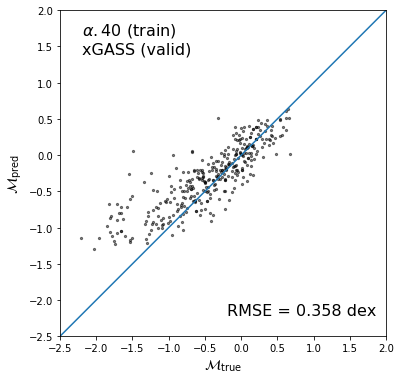

In [166]:
plt.figure(figsize=(6, 6))

plt.scatter(xg[xg.detected].lgGF, xg[xg.detected].fgas_pred, c='k', s=5, alpha=0.5)
# plt.scatter(xg[~xg.detected].lgGF, xg[~xg.detected].fgas_pred, c='C3', s=5, alpha=0.1)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

# plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' + r'Test: $\alpha.40$A (20%)', fontsize=14)
# plt.text(0.1, -2.2, f'RMSE = {((preds - trues)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(preds, trues):.2f}', fontsize=14)

plt.text(-2.2, 1.4, r'$\alpha.40$ (train)' + '\nxGASS (valid)', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((xg[xg.detected].lgGF - xg[xg.detected].fgas_pred)**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


## NIBLES detectability/predictions

In [161]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)]

nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)
nibles.nibles_id = nibles.nibles_id.astype(str)

In [179]:
nibles

,nibles_id,ra,dec,z,logMstar,logMHI,logsSFR,W50,peakSNR,logfgas
0,1,0.008750,15.881694,0.020000,9.74,9.06,-9.96,214,3.4,-0.67
1,2,0.053333,1.120194,0.024653,10.18,9.82,-10.15,233,5.0,-0.36
2,5,0.391458,15.081556,0.021173,9.57,9.53,-9.75,117,6.1,-0.03
3,6,0.561542,14.487775,0.017103,8.67,9.41,-9.77,178,6.1,0.74
4,7,0.797083,15.965694,0.037393,11.31,10.19,-12.02,700,5.7,-1.12
...,...,...,...,...,...,...,...,...,...,...
936,2556,354.608333,15.386361,0.013280,8.78,8.51,-10.17,142,2.6,-0.28
937,2570,355.982917,0.218083,0.022090,10.25,8.91,-11.93,178,2.5,-1.34
938,2573,356.125333,0.320472,0.022017,10.63,9.14,-11.84,221,3.0,-1.49
939,2579,357.187917,15.928750,0.026160,9.93,8.89,-10.10,64,2.9,-1.04


In [162]:
nibles_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['nibles_id'], pref=f'{PATH}/images-nibles_cleaned/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [163]:
nibles_dls = ImageDataLoaders.from_dblock(nibles_dblock, nibles, path=PATH, bs=1)

In [164]:
nibles_preds, nibles_trues = learn.get_preds(dl=nibles_dls.train)

In [175]:
nibles_preds = to_np(nibles_preds.view(-1))
nibles_trues = to_np(nibles_trues.view(-1))

In [177]:
# get detections
nd_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ModifiedColReader(['objID'], pref=(f'{PATH}/images-OC/'), suff='.jpg'),
    get_y=Pipeline([ColReader(['detected'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

nd_dls = ImageDataLoaders.from_dblock(nd_dblock, combined, path=PATH, bs=64)

model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)
learn = Learner(nd_dls, model, opt_func=ranger, metrics=[accuracy, RocAuc()])

learn = learn.load('fastai2-xresnet34-non_detections-2');

In [195]:
nibles_p_detection = np.array([to_np(learn.predict(f'{PATH}/images-nibles_cleaned/{fn}.jpg')[2][1]) for fn in nibles.nibles_id])

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

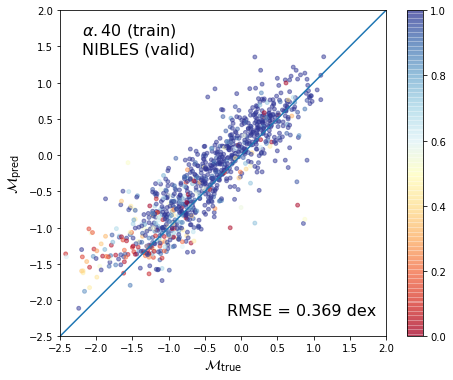

In [210]:
plt.figure(figsize=(7.5, 6))

sc = plt.scatter(nibles_trues, nibles_preds, c=nibles_p_detection, s=15, alpha=0.5, vmin=0, vmax=1, cmap='RdYlBu')
plt.colorbar(sc)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.2, 1.4, r'$\alpha.40$ (train)' + '\nNIBLES (valid)', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((nibles_trues - nibles_preds)**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


# Retrain with label-smoothing ~~and redshift distribution matching~~

In [263]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})
nd = pd.read_csv(f'{PATH}/results/nondetections/a100-nd_himass_lowz.csv', dtype={'objID': str})

nd['detected'] = False
a40['detected'] = True

a40['objID'] = a40.AGCNr.astype(str)
nd.objID = nd.objID.astype(str)

combined = pd.concat([
    a40[['objID', 'detected']],
    nd[['objID', 'detected']].sample(7399, random_state=seed)
])

In [264]:
nd_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ModifiedColReader(['objID'], pref=(f'{PATH}/images-OC/'), suff='.jpg'),
    get_y=Pipeline([ColReader(['detected'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

nd_dls = ImageDataLoaders.from_dblock(nd_dblock, combined, path=PATH, bs=64)

In [265]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)

learn = Learner(
    nd_dls, 
    model, 
    opt_func=ranger, 
    loss_func=LabelSmoothingCrossEntropy(eps=0.05), 
    metrics=[accuracy, RocAuc()]
)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


In [ ]:
learn.fit_one_cycle(40, 1e-2)

In [266]:
# learn.save('fastai2-xresnet34-non_detections_smoothed');
learn = learn.load('fastai2-xresnet34-non_detections_smoothed');

## Make non-detection sample with same redshift distribution as ALFAFLA

In [156]:
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', dtype={'logfgas': float}).join(
    pd.read_csv(f'{PATH}/data/a40.datafile3.csv', index_col='AGCNr',),
    on='AGCNr'
)
nd = pd.read_csv(f'{PATH}/results/nondetections/a100-nd_himass_lowz.csv', dtype={'objID': str})

a40['objID'] = a40.AGCNr.astype(str)
nd.objID = nd.objID.astype(str)

a40['detected'] = True
nd['detected'] = False



In [236]:
z_bins = pd.interval_range(start=0., end=0.07, freq=0.01, closed='left')
z_counts = pd.cut(a40.z_sdss, z_bins).value_counts()

In [237]:
z_counts

[0.02, 0.03)    2202
[0.03, 0.04)    1972
[0.04, 0.05)    1350
[0.01, 0.02)     875
[0.05, 0.06)     508
[0.0, 0.01)      477
[0.06, 0.07)       0
Name: z_sdss, dtype: int64

In [238]:
pd.cut(nd.z, z_bins).value_counts()

[0.05, 0.06)    7366
[0.04, 0.05)    5686
[0.02, 0.03)    5110
[0.03, 0.04)    4512
[0.01, 0.02)     778
[0.0, 0.01)      250
[0.06, 0.07)       0
Name: z, dtype: int64

In [239]:
# sample with replacement

subsamples = []

for z_range, N_samples in zip(z_bins, z_counts):
    subsamples.append(
        nd[(nd.z >= z_range.left) & (nd.z < z_range.right)].sample(n=N_samples, replace=True, random_state=seed)
    )
    


In [240]:
subsamples = pd.concat(subsamples, axis=0).reset_index()

In [242]:
combined = pd.concat([
    a40[['objID', 'detected']],
    subsamples[['objID', 'detected']]
])

combined.sample(5)

,objID,detected
7039,1237665330400919641,False
1555,1237655125547155483,False
6941,1237665441515831426,False
4142,1237667209981657164,False
4328,713043,True


In [243]:
nd_dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ModifiedColReader(['objID'], pref=(f'{PATH}/images-OC/'), suff='.jpg'),
    get_y=Pipeline([ColReader(['detected'])]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(nd_dblock, combined, path=PATH, bs=64)

In [244]:
model = xresnet34(sa=True, act_cls=MishCuda, n_out=2)

learn = Learner(
    nd_dls, 
    model, 
    opt_func=ranger, 
    loss_func=LabelSmoothingCrossEntropy(eps=0.05), 
    metrics=[accuracy, RocAuc()]
)

@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


In [245]:
learn.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.524894,0.496395,0.773910,0.769517,01:08
1,0.475586,0.446176,0.805002,0.806810,01:02
2,0.461915,0.434120,0.819534,0.819000,01:02
3,0.459778,0.488055,0.794187,0.795658,01:02
4,0.450902,0.516971,0.771206,0.775413,01:02
5,0.471631,0.460823,0.805002,0.801488,01:02
6,0.458429,0.633491,0.688408,0.696906,01:02
7,0.454100,0.437849,0.819534,0.817197,01:02
8,0.450285,0.405779,0.846232,0.843086,01:02
9,0.419212,0.397197,0.840487,0.842885,01:03


In [246]:
# learn.save('fastai2-xresnet34-non_detections_smoothed_zmatched');
learn = learn.load('fastai2-xresnet34-non_detections_smoothed_zmatched');

## Test NIBLES

In [267]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)]

nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)
nibles.nibles_id = nibles.nibles_id.astype(str)

In [268]:
nibles_p_detection = np.array([to_np(learn.predict(f'{PATH}/images-nibles_cleaned/{fn}.jpg')[2][1]) for fn in nibles.nibles_id])

In [270]:
# predictions
model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [271]:
nibles_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['nibles_id'], pref=f'{PATH}/images-nibles_cleaned/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [272]:
nibles_dls = ImageDataLoaders.from_dblock(nibles_dblock, nibles, path=PATH, bs=1)

nibles_preds, nibles_trues = learn.get_preds(dl=nibles_dls.train)
nibles_preds = to_np(nibles_preds.view(-1))
nibles_trues = to_np(nibles_trues.view(-1))

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

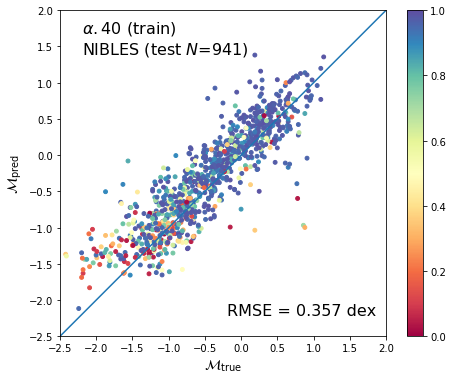

In [276]:
plt.figure(figsize=(7.5, 6))

sc = plt.scatter(nibles_trues, nibles_preds, c=nibles_p_detection, s=15, vmin=0, vmax=1, cmap='Spectral')
plt.colorbar(sc)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.2, 1.4, r'$\alpha.40$ (train)' + f'\nNIBLES (test $N$={len(nibles_trues)})', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((nibles_trues[nibles_p_detection > 0.5] - nibles_preds[nibles_p_detection > 0.5])**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


In [331]:
sum(nibles_p_detection > 0.5)

804

In [274]:
slope(nibles_preds[nibles_p_detection > 0.5], nibles_trues[nibles_p_detection > 0.5])

0.8471883

In [275]:
# mean offset of 0.14 dex
(nibles_preds[nibles_p_detection > 0.5] - nibles_trues[nibles_p_detection > 0.5]).mean()

0.14869799

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

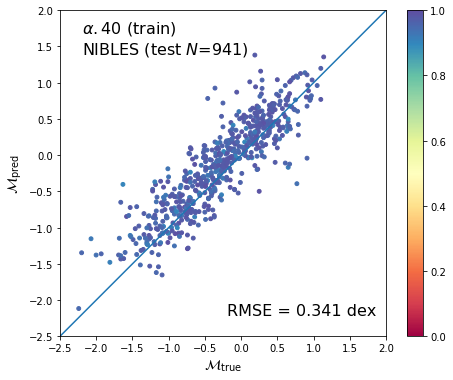

In [340]:
plt.figure(figsize=(7.5, 6))

sc = plt.scatter(nibles_trues[nibles_p_detection > 0.9], nibles_preds[nibles_p_detection > 0.9], c=nibles_p_detection[nibles_p_detection > 0.9], s=15, vmin=0, vmax=1, cmap='Spectral')
plt.colorbar(sc)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.2, 1.4, r'$\alpha.40$ (train)' + f'\nNIBLES (test $N$={len(nibles_trues)})', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((nibles_trues[nibles_p_detection > 0.9] - nibles_preds[nibles_p_detection > 0.9])**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


In [342]:
sum(nibles_p_detection > 0.9)

601

In [343]:
slope(nibles_preds[nibles_p_detection > 0.9], nibles_trues[nibles_p_detection > 0.9])

0.8662146

## Test xGASS

In [269]:
xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

xgass_p_detection = np.array([to_np(learn.predict(f'{PATH}/images-xGASS/{fn}.jpg')[2][1]) for fn in xg.GASS])

In [281]:
# predictions
a40 = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv', usecols=(1,2), dtype={'AGCNr': str, 'logfgas': float})

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['AGCNr'], pref=f'{PATH}/images-OC/', suff='.jpg'),
    get_y=Pipeline([ColReader(['logfgas'], label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, a40, path=PATH, bs=64)

model = xresnet34(sa=True, act_cls=MishCuda, n_out=1)
learn = Learner(dls, model, loss_func=root_mean_squared_error, opt_func=ranger)
learn = learn.load('fastai2-xresnet34-a40A-1');

In [282]:
xg_dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader(['GASS'], pref=f'{PATH}/images-xGASS/', suff='.jpg'),
    get_y=Pipeline([ColReader(['lgGF'], label_delim=None)]),
    splitter=FuncSplitter(lambda x: False),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

In [283]:
xg_dls = ImageDataLoaders.from_dblock(xg_dblock, xg, path=PATH, bs=1)

xg_preds, xg_trues = learn.get_preds(dl=xg_dls.train)
xg_preds = to_np(xg_preds.view(-1))
xg_trues = to_np(xg_trues.view(-1))

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

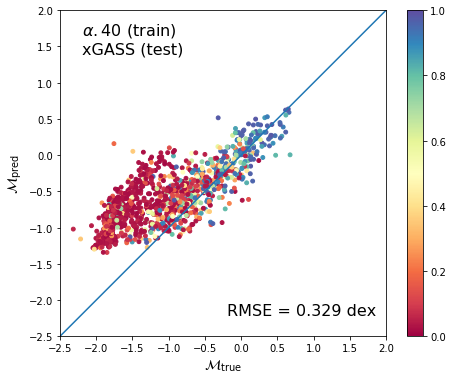

In [284]:
plt.figure(figsize=(7.5, 6))

sc = plt.scatter(xg_trues, xg_preds, c=xgass_p_detection, s=15, vmin=0, vmax=1, cmap='Spectral')
plt.colorbar(sc)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.2, 1.4, r'$\alpha.40$ (train)' + '\nxGASS (test)', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((xg_trues[xgass_p_detection > 0.5] - xg_preds[xgass_p_detection > 0.5])**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


In [285]:
sum(xgass_p_detection > 0.5)

326

Text(0, 0.5, '$\\mathcal{M}_{\\rm pred}$')

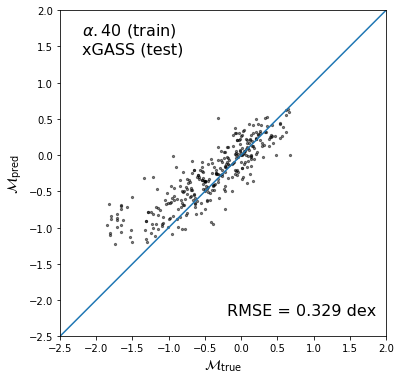

In [288]:
plt.figure(figsize=(6, 6))

plt.scatter(xg_trues[xgass_p_detection > 0.5], xg_preds[xgass_p_detection > 0.5], c='k', s=5, alpha=0.5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.2, 1.4, r'$\alpha.40$ (train)' + '\nxGASS (test)', fontsize=16)
plt.text(-0.2, -2.2, f'RMSE = {((xg_trues[xgass_p_detection > 0.5] - xg_preds[xgass_p_detection > 0.5])**2).mean()**0.5:.3f} dex', fontsize=16)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=14)


In [287]:
slope(xg_preds[xgass_p_detection > 0.5], xg_trues[xgass_p_detection > 0.5])

0.6434027

## Using T17 PR on xGASS

In [289]:
import astropy.io.ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

In [290]:
xg['fgas_pred'] = xg_preds

In [291]:
t17 = astropy.io.ascii.read(f'{PATH}/data/Teimoorinia+17.csv').to_pandas().loc[2:]

t17 = t17.astype(
    {
        'SDSS': np.int64, 'RAJ2000': float, 'DEJ2000': float, 'z': float, 
        'logM*': float, 'logMHI/M*': float, 'Cfgas': float, 'PR': float,
        'sigmafitN': float, 'sigmafit': float, 'sigmafgas': float, 'Sloan': str
    }
)

t17.sample(3)

,SDSS,RAJ2000,DEJ2000,z,logM*,logMHI/M*,Cfgas,PR,sigmafitN,sigmafit,sigmafgas,Sloan
406303,587738409255698620,159.769557,12.680005,0.094396,10.759,-0.60713,0.70454,0.85550,0.72350,0.02390,0.21466,Sloan
385974,588015510350135414,16.084595,0.949484,0.145545,10.875,-0.65403,0.44692,0.60903,0.64468,0.04228,0.31702,Sloan
403321,587731512612487206,34.055427,-0.027698,0.025383,9.597,-0.02228,0.74294,0.77838,0.83852,0.01040,0.20191,Sloan


In [292]:
xg_coords = SkyCoord(xg.RA, xg.DEC, unit=u.deg)
t17_coords = SkyCoord(t17.RAJ2000, t17.DEJ2000, unit=u.deg)

In [293]:
cutoff = 1 / 3600 # deg
idx_t17, idx_xg, _, _ = xg_coords.search_around_sky(t17_coords, cutoff*u.deg)

In [294]:
len(list(idx_xg)), len(set(idx_xg)), len(list(idx_t17)), len(set(idx_t17))

(1012, 1012, 1012, 1012)

In [295]:
t17_x_xg = t17.iloc[idx_t17]
xg_x_t17 = xg.iloc[idx_xg]

xg_x_t17.reset_index(drop=True, inplace=True)
t17_x_xg.reset_index(inplace=True)

t17_x_xg = t17_x_xg.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)

xg_x_t17 = xg_x_t17.join(t17_x_xg, rsuffix='_T17')


In [296]:
xg_x_t17.columns

Index(['GASS', 'AGCnr', 'SDSS', 'PLATEID', 'MJD', 'FIBERID', 'RA', 'DEC',
       'zSDSS', 'Dlum', 'lgMstar', 'expAB_r', 'model_r', 'merr_r', 'ext_r',
       'petrR50_r', 'petrR90_r', 'petrR50_z', 'lgmust', 'CINDX', 'INCL',
       'NUVr', 'lgSFR_tot_median', 'SFR_best', 'SFRerr_best', 'SFRcase_best',
       'HIsrc', 'HI_FLAG', 'xGASSDR', 'zHI', 'W50cor', 'lgMHI', 'lgGF',
       'HIconf_flag', 'weight', 'group_id_B', 'NYU_id', 'env_code_B', 'Ngal_B',
       'yang_shred_code', 'logMh_Mst_B', 'lvir_ratB', 'fgas_pred', 'index',
       'SDSS_T17', 'RAJ2000', 'DEJ2000', 'z_t17', 'logM*', 'fgas_t17', 'Cfgas',
       'PR', 'sigmafitN', 'sigmafit', 'sigmafgas', 'Sloan'],
      dtype='object')

(array([  4.,   9.,  54., 296., 494.,  95.,  45.,   9.,   1.,   5.]),
 array([-56.4    , -41.42406, -26.44812, -11.47218,   3.50376,  18.4797 ,
         33.45564,  48.43158,  63.40752,  78.38346,  93.3594 ]),
 <a list of 10 Patch objects>)

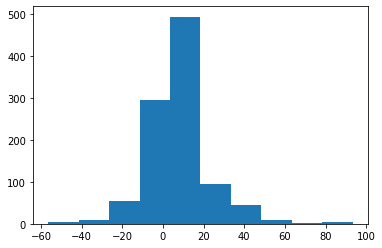

In [297]:
# all within < 100 km/s
plt.hist(3e5 * (xg_x_t17.z_t17 - xg_x_t17.zSDSS)) 

In [298]:
xg_x_t17 = xg_x_t17.rename({'lgGF': 'fgas_true'}, axis=1)

In [299]:
rmse_ours = np.mean((xg_x_t17.fgas_true - xg_x_t17.fgas_pred)**2)**0.5
rmse_t17 = np.mean((xg_x_t17.fgas_true - xg_x_t17.fgas_t17)**2)**0.5

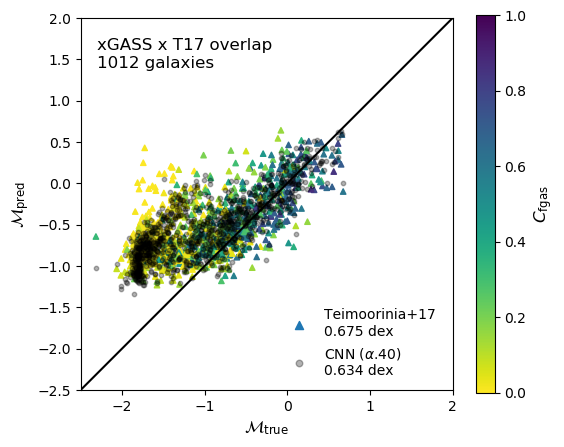

In [300]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(xg_x_t17.fgas_true, xg_x_t17.fgas_t17, c=xg_x_t17.Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0, vmax=1, label=f'Teimoorinia+17 \n{rmse_t17:.3f} dex')
plt.scatter(xg_x_t17.fgas_true, xg_x_t17.fgas_pred, c='k', alpha=0.3, s=10, label=r'CNN ($\alpha$.40)' f'\n{rmse_ours:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, 'xGASS x T17 overlap' '\n' f'{len(xg_x_t17)} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [301]:
# with T17 cut
T17_cut = (xg_x_t17.sigmafit < 0.1) & (xg_x_t17.Cfgas > 0.5)


In [302]:
rmse_T17_cut = ((xg_x_t17[T17_cut].fgas_true - xg_x_t17[T17_cut].fgas_t17)**2).mean()**0.5
rmse_ours_cut = ((xg_x_t17[T17_cut].fgas_true - xg_x_t17[T17_cut].fgas_pred)**2).mean()**0.5

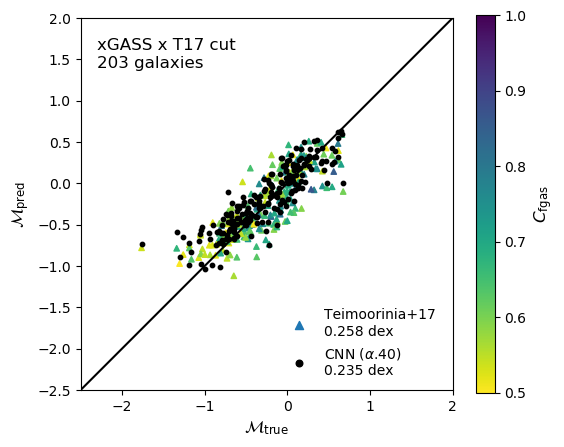

In [303]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(xg_x_t17[T17_cut].fgas_true, xg_x_t17[T17_cut].fgas_t17, c=xg_x_t17[T17_cut].Cfgas, cmap='viridis_r', marker='^', s=15, vmin=0.5, vmax=1, label=f'Teimoorinia+17 \n{rmse_T17_cut:.3f} dex')
plt.scatter(xg_x_t17[T17_cut].fgas_true, xg_x_t17[T17_cut].fgas_pred, c='k', s=10, label=r'CNN ($\alpha$.40)' f'\n{rmse_ours_cut:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, 'xGASS x T17 cut' '\n' f'{len(xg_x_t17[T17_cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [304]:
print(f'T17 slope: {slope(xg_x_t17[T17_cut].fgas_t17, xg_x_t17[T17_cut].fgas_true):.3f}')
print(f'our slope: {slope(xg_x_t17[T17_cut].fgas_pred, xg_x_t17[T17_cut].fgas_true):.3f}')

T17 slope: 0.713
our slope: 0.718


## Using our PR and T17 predictions

In [327]:
xg_x_t17['p_cnn'] = xgass_p_detection[idx_xg]

our_cut = xg_x_t17.p_cnn > 0.5

rmse_T17_our_cut = ((xg_x_t17[our_cut].fgas_true - xg_x_t17[our_cut].fgas_t17)**2).mean()**0.5
rmse_cnn_our_cut = ((xg_x_t17[our_cut].fgas_true - xg_x_t17[our_cut].fgas_pred)**2).mean()**0.5

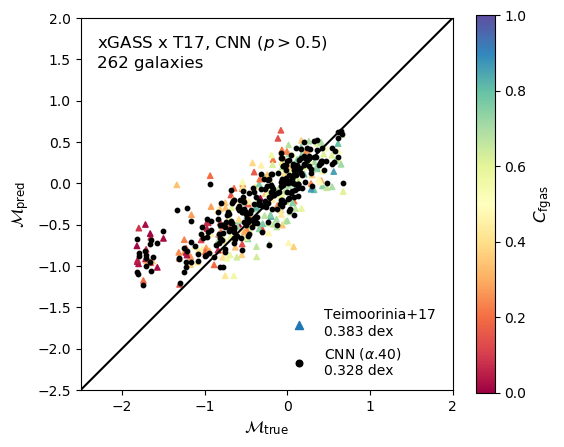

In [328]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(xg_x_t17[our_cut].fgas_true, xg_x_t17[our_cut].fgas_t17, c=xg_x_t17[our_cut].Cfgas, cmap='Spectral', marker='^', s=15, vmin=0.0, vmax=1, label=f'Teimoorinia+17 \n{rmse_T17_our_cut:.3f} dex')
plt.scatter(xg_x_t17[our_cut].fgas_true, xg_x_t17[our_cut].fgas_pred, c='k', s=10, label=r'CNN ($\alpha$.40)' f'\n{rmse_cnn_our_cut:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, 'xGASS x T17, CNN ($p>0.5$)' '\n' f'{len(xg_x_t17[our_cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [329]:
our_cut = xg_x_t17.p_cnn > 0.9

rmse_T17_our_cut = ((xg_x_t17[our_cut].fgas_true - xg_x_t17[our_cut].fgas_t17)**2).mean()**0.5
rmse_cnn_our_cut = ((xg_x_t17[our_cut].fgas_true - xg_x_t17[our_cut].fgas_pred)**2).mean()**0.5

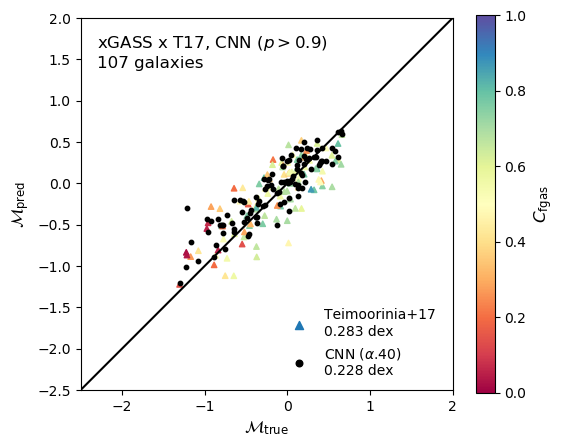

In [330]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(xg_x_t17[our_cut].fgas_true, xg_x_t17[our_cut].fgas_t17, c=xg_x_t17[our_cut].Cfgas, cmap='Spectral', marker='^', s=15, vmin=0.0, vmax=1, label=f'Teimoorinia+17 \n{rmse_T17_our_cut:.3f} dex')
plt.scatter(xg_x_t17[our_cut].fgas_true, xg_x_t17[our_cut].fgas_pred, c='k', s=10, label=r'CNN ($\alpha$.40)' f'\n{rmse_cnn_our_cut:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, 'xGASS x T17, CNN ($p>0.9$)' '\n' f'{len(xg_x_t17[our_cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [319]:
print(f'T17 slope: {slope(xg_x_t17[our_cut].fgas_t17, xg_x_t17[our_cut].fgas_true):.3f}')
print(f'our slope: {slope(xg_x_t17[our_cut].fgas_pred, xg_x_t17[our_cut].fgas_true):.3f}')

T17 slope: 0.722
our slope: 0.743


## Compare NIBLES x T17

In [349]:
nibles.shape

(941, 10)

In [353]:
nibles['fgas_pred'] = nibles_preds
nibles['fgas_true'] = nibles_trues
nibles['p_cnn'] = nibles_p_detection

ni_coords = SkyCoord(nibles.ra, nibles.dec, unit=u.deg)
idx_t17, idx_ni, _, _ = ni_coords.search_around_sky(t17_coords, 1/3600*u.deg)

In [357]:
t17_x_ni = t17.iloc[idx_t17]
ni_x_t17 = nibles.iloc[idx_ni]

In [358]:
ni_x_t17.reset_index(drop=True, inplace=True)
t17_x_ni.reset_index(inplace=True)

t17_x_ni = t17_x_ni.rename({'z': 'z_t17', 'logMHI/M*': 'fgas_t17'}, axis=1)
ni_x_t17 = ni_x_t17.join(t17_x_ni)

ni_x_t17 = ni_x_t17[3e5*np.abs(ni_x_t17.z_t17 - ni_x_t17.z) <= 50] # velocity cut

In [359]:

our_cut = ni_x_t17.p_cnn > 0.5

rmse_T17_our_cut = ((ni_x_t17[our_cut].fgas_true - ni_x_t17[our_cut].fgas_t17)**2).mean()**0.5
rmse_cnn_our_cut = ((ni_x_t17[our_cut].fgas_true - ni_x_t17[our_cut].fgas_pred)**2).mean()**0.5

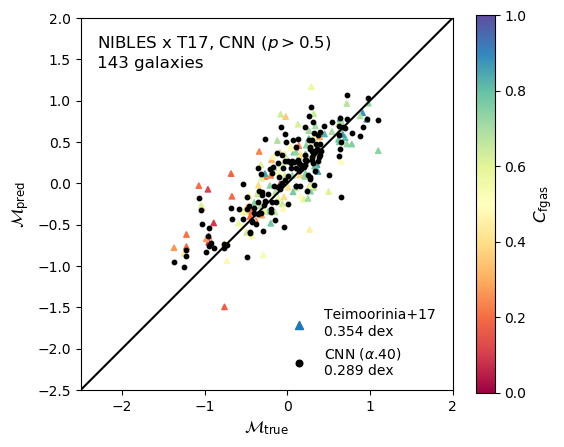

In [360]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17[our_cut].fgas_true, ni_x_t17[our_cut].fgas_t17, c=ni_x_t17[our_cut].Cfgas, cmap='Spectral', marker='^', s=15, vmin=0.0, vmax=1, label=f'Teimoorinia+17 \n{rmse_T17_our_cut:.3f} dex')
plt.scatter(ni_x_t17[our_cut].fgas_true, ni_x_t17[our_cut].fgas_pred, c='k', s=10, label=r'CNN ($\alpha$.40)' f'\n{rmse_cnn_our_cut:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, 'NIBLES x T17, CNN ($p>0.5$)' '\n' f'{len(ni_x_t17[our_cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [361]:
print(f'T17 slope: {slope(ni_x_t17[our_cut].fgas_t17, ni_x_t17[our_cut].fgas_true):.3f}')
print(f'our slope: {slope(ni_x_t17[our_cut].fgas_pred, ni_x_t17[our_cut].fgas_true):.3f}')

T17 slope: 0.715
our slope: 0.789


In [362]:

our_cut = ni_x_t17.p_cnn > 0.9

rmse_T17_our_cut = ((ni_x_t17[our_cut].fgas_true - ni_x_t17[our_cut].fgas_t17)**2).mean()**0.5
rmse_cnn_our_cut = ((ni_x_t17[our_cut].fgas_true - ni_x_t17[our_cut].fgas_pred)**2).mean()**0.5

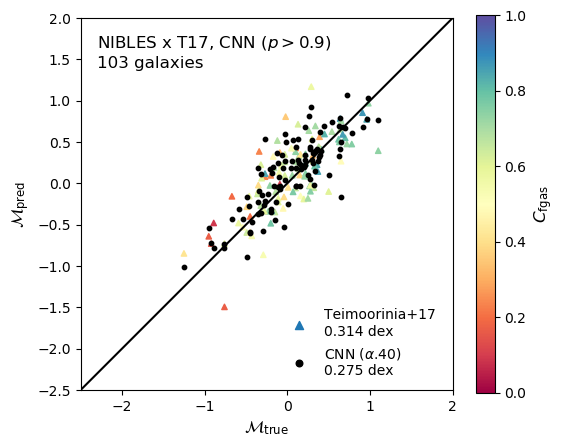

In [363]:
plt.figure(figsize=(6, 5), dpi=100)
sc = plt.scatter(ni_x_t17[our_cut].fgas_true, ni_x_t17[our_cut].fgas_t17, c=ni_x_t17[our_cut].Cfgas, cmap='Spectral', marker='^', s=15, vmin=0.0, vmax=1, label=f'Teimoorinia+17 \n{rmse_T17_our_cut:.3f} dex')
plt.scatter(ni_x_t17[our_cut].fgas_true, ni_x_t17[our_cut].fgas_pred, c='k', s=10, label=r'CNN ($\alpha$.40)' f'\n{rmse_cnn_our_cut:.3f} dex')
cbar = plt.colorbar(sc)
cbar.set_label(r'$C_{\rm fgas}$', fontsize=12)

plt.plot([-2.5, 2], [-2.5, 2], c='k')
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, 'NIBLES x T17, CNN ($p>0.9$)' '\n' f'{len(ni_x_t17[our_cut])} galaxies', fontsize=12)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
plt.ylabel(r'$\mathcal{M}_{\rm pred}$', fontsize=12)

plt.legend(loc='lower right', framealpha=0, markerscale=1.5)

In [364]:
print(f'T17 slope: {slope(ni_x_t17[our_cut].fgas_t17, ni_x_t17[our_cut].fgas_true):.3f}')
print(f'our slope: {slope(ni_x_t17[our_cut].fgas_pred, ni_x_t17[our_cut].fgas_true):.3f}')

T17 slope: 0.770
our slope: 0.831
